In [123]:
# This injects fake planets by (and without using PynPoint)
# 1.  Determining a mask over the host star PSF where nonlinearity/saturation may be an issue
# 2.  Fitting a first PCA basis to the masked host star PSF (using UN-saturated frames as the basis set)
# 3.  Reconstructing the ideal, unsaturated host star PSF for making fake planets
# 4.  Injecting it with a variety of amplitudes/angles around the host star
# 5.  Fitting a second PCA basis to the NON-masked host star PSF (using saturated frames as the basis set)
# 6.  Reconstructing the saturated host star PSF for host star subtraction
# 7.  Subtracting the host star PSF
# 8.  Doing ADI

# created 2019 Jan. 11 by E.S.

## SECTION TO INITIALIZE

In [1]:
import urllib
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import sklearn
from sklearn.decomposition import PCA
from sklearn.decomposition import RandomizedPCA
import time
from matplotlib.colors import LogNorm
import pandas as pd
from regions import PixCoord, CircleSkyRegion, CirclePixelRegion, PolygonPixelRegion

In [2]:
import os
from astropy.io import fits
from astropy.modeling import models, fitting

In [3]:
# stem 

stem_base = ('/home/../../media/unasemaje/Elements/lbti_data_reduction/180507_fizeau_altair/')
stem_retrieve = (stem_base+'05_centered/') # use frames which have already been centered and are well-behaved, for now
stem_place = (stem_base+'testing/')

# READ IN PSF FRAMES TO FORM THE BASIS SET

In [127]:
def make_pca_basis_cube_from_readouts(stem_retrieve,
                                      stem_place,
                                      write_string,
                                      startFrame,
                                      endFrame,
                                      lmir_fw1,
                                      lmir_fw2,
                                      lmir_fw25,
                                      lmir_fw3,
                                      lmir_fw4,
                                      pcclosed,
                                      actexp,
                                      n_PCA):
    '''
    INPUTS
    stem_retrieve: filename stem for retrieving data
    stem_place: stem of path for saving output
    write_string: an extra string to put in filenames
    startFrame: the first frame of the training set
    endFrame: the last frame of the training set
    lmir_fw1: desired status of LMIR FW1
    lmir_fw2: desired status of LMIR FW2
    lmir_fw25: desired status of LMIR FW2.5
    lmir_fw3: desired status of LMIR FW3
    lmir_fw4: desired status of LMIR FW4
    pcclosed: desired status of phase: closed or open?
    actexp: desired status of exposure time (in ms)
    n_PCA: number of PCA components to generate
    
    OUTPUTS
    (none; FITS files are written out)
    
    N.b. The first version of this function appeared in make_pca_background_basis_cube.ipynb
    '''
    
    # initialize counter
    counter = 0
    
    test_cube = np.nan*np.ones((endFrame-startFrame+1,100,100),dtype = np.int64)
    
    # loop through each training set image and add it to a cube (endFrame is inclusive)
    print('Putting training frames into cube...')
    for framenum in range(startFrame,endFrame+1): #endFrame+1): # 83, 67108
            
        # raw data (except that readout glitch correction has been done)
        filename = 'lm_180507_'+str("{:0>6d}".format(framenum))+'_nPCA164.fits'
        img_string = stem_retrieve + filename
    
        # if FITS file exists in the first place
        if ((np.mod(framenum,1) == 0) & os.path.isfile(img_string)): 
            
            # read in image
            sciImg, header = fits.getdata(img_string,0,header=True)
            
            # check header fields for filters, integration times, phase control
            if (header["LMIR_FW1"]==lmir_fw1 and header["LMIR_FW2"]==lmir_fw2 
                and header["LMIRFW25"]==lmir_fw25 and header["LMIR_FW3"]==lmir_fw3
                and header["LMIR_FW4"]==lmir_fw4 and header["ACTEXP"]==actexp
                and header["PCCLOSED"]==pcclosed):
                
                print("Reading in " + filename)
        
                # add to cube
                test_cube[counter,:,:] = sciImg
                
                # advance the counter
                counter += 1
                
                ## ## TESTING 
                #plt.imshow(sciImg)
                #plt.imshow(test_cube[counter,:,:])
                #plt.show()
                
                ## ## TESTING
                #print(counter)

            else:
                
                print("NOT READING IN " + filename)
                continue # skip and move to next frame
            
        else:
            
            print('Hang on-- frame '+img_string+' not found!')
    
    # remove leftover slices of all nans
    test_cube = test_cube[0:counter,:,:]
    
    # at this point, test_cube holds the frames to be used as a training set
    
    # flatten each individual frame into a 1D array
    print('Flattening the training cube...')
    
    ## ## TESTING
    print(np.shape(test_cube))
    
    test_cube_1_1ds = np.reshape(test_cube,
                                 (np.shape(test_cube)[0],
                                  np.shape(test_cube)[1]*np.shape(test_cube)[2])) 

    ## ## TESTING
    print(np.shape(test_cube_1_1ds))
    print(test_cube_1_1ds[0])
    
    ## carefully remove nans before doing PCA
    
    # indices of finite elements over a single flattened frame
    idx = np.isfinite(test_cube_1_1ds[0,:])
        
    # reconstitute only the finite elements together in another PCA cube of 1D slices
    training_set_1ds_noNaN = np.nan*np.ones((len(test_cube_1_1ds[:,0]),np.sum(idx))) # initialize array with slices the length of number of finite elements
    for t in range(0,len(test_cube_1_1ds[:,0])): # for each PCA component, populate the arrays without nans with the finite elements
        training_set_1ds_noNaN[t,:] = test_cube_1_1ds[t,idx]
    
    # do PCA on the flattened `cube' with no NaNs
    print('Doing PCA...')
    #pca = PCA(n_components=n_PCA, svd_solver='randomized') # initialize object
    pca = RandomizedPCA(n_PCA) # for Python 2.7 
    
    ## ## TESTING
    print(np.shape(training_set_1ds_noNaN))
    #for i in range(0,len(training_set_1ds_noNaN)):
    #    print(training_set_1ds_noNaN[i,0:4])
    
    test_pca = pca.fit(training_set_1ds_noNaN) # calculate PCA basis set
    del training_set_1ds_noNaN # clear memory
    
    # reinsert the NaN values into each 1D slice of the PCA basis set
    print('Putting PCA components into cube...')
    pca_comp_cube = np.nan*np.ones((n_PCA,
                                    np.shape(test_cube)[1],
                                    np.shape(test_cube)[2]), 
                                   dtype = np.float32) # initialize a cube of 2D slices
    for slicenum in range(0,n_PCA): # for each PCA component, populate the arrays without nans with the finite elements
        pca_masked_1dslice_noNaN = np.nan*np.ones((len(test_cube_1_1ds[0,:]))) # initialize a new 1d frame long enough to contain all pixels
        pca_masked_1dslice_noNaN[idx] = pca.components_[slicenum] # put the finite elements into the right positions
        pca_comp_cube[slicenum,:,:] = np.reshape(pca_masked_1dslice_noNaN,
                                                 (np.shape(test_cube)[1],
                                                  np.shape(test_cube)[2])).astype(np.float32)
        

    # save input cube FYI
    print('Saving input cube...')
    hdu = fits.PrimaryHDU(test_cube.astype(np.float32))
    del test_cube # clear memory
    hdul = fits.HDUList([hdu])
    write_name = stem_place + 'pca_input_reference_cube_'+write_string+'.fits'
    hdul.writeto(write_name, overwrite=True)
        
    # save PCA vector cube
    print('Saving PCA cube...')
    t = time.time()
    hdu = fits.PrimaryHDU(pca_comp_cube.astype(np.float32))
    del pca_comp_cube # clear memory
    hdul = fits.HDUList([hdu])
    write_name = stem_place + write_string + '.fits'
    hdul.writeto(write_name, overwrite=True)
    
    elapsed = time.time() - t
    print(elapsed)
    print('PCA cube saved as '+write_name)
    print('---')
    

In [5]:
# make PCA basis of UN-saturated PSFs

make_pca_basis_cube_from_readouts(stem_retrieve,
                                      stem_place,
                                      write_string = "pca_test",
                                      startFrame = 7120,
                                      endFrame = 7925,
                                      lmir_fw1 = "94800",
                                      lmir_fw2 = "ND2.0-T1",
                                      lmir_fw25 = "Lspec2.8-4.0",
                                      lmir_fw3 = "Open",
                                      lmir_fw4 = "Br-Alpha-On",
                                      pcclosed = 1,
                                      actexp = 145976,
                                      n_PCA = 100)

Putting training frames into cube...
NOT READING IN lm_180507_007120_nPCA164.fits
NOT READING IN lm_180507_007121_nPCA164.fits
NOT READING IN lm_180507_007122_nPCA164.fits
Reading in lm_180507_007123_nPCA164.fits
NOT READING IN lm_180507_007124_nPCA164.fits
NOT READING IN lm_180507_007125_nPCA164.fits
NOT READING IN lm_180507_007126_nPCA164.fits
NOT READING IN lm_180507_007127_nPCA164.fits
NOT READING IN lm_180507_007128_nPCA164.fits
NOT READING IN lm_180507_007129_nPCA164.fits
NOT READING IN lm_180507_007130_nPCA164.fits
NOT READING IN lm_180507_007131_nPCA164.fits
NOT READING IN lm_180507_007132_nPCA164.fits
NOT READING IN lm_180507_007133_nPCA164.fits
NOT READING IN lm_180507_007134_nPCA164.fits
NOT READING IN lm_180507_007135_nPCA164.fits
NOT READING IN lm_180507_007136_nPCA164.fits
NOT READING IN lm_180507_007137_nPCA164.fits
NOT READING IN lm_180507_007138_nPCA164.fits
NOT READING IN lm_180507_007139_nPCA164.fits
NOT READING IN lm_180507_007140_nPCA164.fits
NOT READING IN lm_1805

NOT READING IN lm_180507_007350_nPCA164.fits
NOT READING IN lm_180507_007351_nPCA164.fits
NOT READING IN lm_180507_007352_nPCA164.fits
NOT READING IN lm_180507_007353_nPCA164.fits
NOT READING IN lm_180507_007354_nPCA164.fits
NOT READING IN lm_180507_007355_nPCA164.fits
NOT READING IN lm_180507_007356_nPCA164.fits
Reading in lm_180507_007357_nPCA164.fits
Reading in lm_180507_007358_nPCA164.fits
Reading in lm_180507_007359_nPCA164.fits
Reading in lm_180507_007360_nPCA164.fits
Reading in lm_180507_007361_nPCA164.fits
Reading in lm_180507_007362_nPCA164.fits
Reading in lm_180507_007363_nPCA164.fits
Reading in lm_180507_007364_nPCA164.fits
Reading in lm_180507_007365_nPCA164.fits
Reading in lm_180507_007366_nPCA164.fits
Reading in lm_180507_007367_nPCA164.fits
Reading in lm_180507_007368_nPCA164.fits
Reading in lm_180507_007369_nPCA164.fits
Reading in lm_180507_007370_nPCA164.fits
Reading in lm_180507_007371_nPCA164.fits
Reading in lm_180507_007372_nPCA164.fits
Reading in lm_180507_007373_n

Reading in lm_180507_007578_nPCA164.fits
Reading in lm_180507_007579_nPCA164.fits
Reading in lm_180507_007580_nPCA164.fits
Reading in lm_180507_007581_nPCA164.fits
Reading in lm_180507_007582_nPCA164.fits
Reading in lm_180507_007583_nPCA164.fits
Reading in lm_180507_007584_nPCA164.fits
Reading in lm_180507_007585_nPCA164.fits
Reading in lm_180507_007586_nPCA164.fits
Reading in lm_180507_007587_nPCA164.fits
Reading in lm_180507_007588_nPCA164.fits
Reading in lm_180507_007589_nPCA164.fits
Reading in lm_180507_007590_nPCA164.fits
Reading in lm_180507_007591_nPCA164.fits
Reading in lm_180507_007592_nPCA164.fits
Reading in lm_180507_007593_nPCA164.fits
Reading in lm_180507_007594_nPCA164.fits
Reading in lm_180507_007595_nPCA164.fits
Reading in lm_180507_007596_nPCA164.fits
Reading in lm_180507_007597_nPCA164.fits
Reading in lm_180507_007598_nPCA164.fits
Reading in lm_180507_007599_nPCA164.fits
Reading in lm_180507_007600_nPCA164.fits
Reading in lm_180507_007601_nPCA164.fits
Reading in lm_18

NOT READING IN lm_180507_007796_nPCA164.fits
NOT READING IN lm_180507_007797_nPCA164.fits
NOT READING IN lm_180507_007798_nPCA164.fits
NOT READING IN lm_180507_007799_nPCA164.fits
NOT READING IN lm_180507_007800_nPCA164.fits
NOT READING IN lm_180507_007801_nPCA164.fits
NOT READING IN lm_180507_007802_nPCA164.fits
NOT READING IN lm_180507_007803_nPCA164.fits
NOT READING IN lm_180507_007804_nPCA164.fits
NOT READING IN lm_180507_007805_nPCA164.fits
NOT READING IN lm_180507_007806_nPCA164.fits
NOT READING IN lm_180507_007807_nPCA164.fits
NOT READING IN lm_180507_007808_nPCA164.fits
NOT READING IN lm_180507_007809_nPCA164.fits
NOT READING IN lm_180507_007810_nPCA164.fits
NOT READING IN lm_180507_007811_nPCA164.fits
NOT READING IN lm_180507_007812_nPCA164.fits
NOT READING IN lm_180507_007813_nPCA164.fits
NOT READING IN lm_180507_007814_nPCA164.fits
NOT READING IN lm_180507_007815_nPCA164.fits
Reading in lm_180507_007816_nPCA164.fits
Reading in lm_180507_007817_nPCA164.fits
Reading in lm_1805

Reading in lm_180507_007923_nPCA164.fits
Reading in lm_180507_007924_nPCA164.fits
Reading in lm_180507_007925_nPCA164.fits
Flattening the training cube...
(487, 100, 100)
(487, 10000)
[-100.23302971  -23.39024303  -46.08873337 ...    0.            0.
    0.        ]
Doing PCA...
(487, 10000)


/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


Putting PCA components into cube...
Saving input cube...
Saving PCA cube...
0.0227289199829
PCA cube saved as /home/../../media/unasemaje/Elements/lbti_data_reduction/180507_fizeau_altair/testing/pca_test.fits
---


In [29]:
# make PCA basis of saturated PSFs

make_pca_basis_cube_from_readouts(stem_retrieve,
                                      stem_place,
                                      write_string = "pca_test2",
                                      startFrame = 8000,
                                      endFrame = 10500,
                                      lmir_fw1 = "94800",
                                      lmir_fw2 = "ND1.0-T10",
                                      lmir_fw25 = "Lspec2.8-4.0",
                                      lmir_fw3 = "Open",
                                      lmir_fw4 = "Br-Alpha-On",
                                      pcclosed = 1,
                                      actexp = 145976,
                                      n_PCA = 100)

Putting training frames into cube...
Reading in lm_180507_008000_nPCA164.fits
Reading in lm_180507_008001_nPCA164.fits
Reading in lm_180507_008002_nPCA164.fits
Reading in lm_180507_008003_nPCA164.fits
Reading in lm_180507_008004_nPCA164.fits
Reading in lm_180507_008005_nPCA164.fits
Reading in lm_180507_008006_nPCA164.fits
Reading in lm_180507_008007_nPCA164.fits
Reading in lm_180507_008008_nPCA164.fits
Reading in lm_180507_008009_nPCA164.fits
Reading in lm_180507_008010_nPCA164.fits
Reading in lm_180507_008011_nPCA164.fits
Reading in lm_180507_008012_nPCA164.fits
Reading in lm_180507_008013_nPCA164.fits
Reading in lm_180507_008014_nPCA164.fits
Reading in lm_180507_008015_nPCA164.fits
Reading in lm_180507_008016_nPCA164.fits
Reading in lm_180507_008017_nPCA164.fits
Reading in lm_180507_008018_nPCA164.fits
Reading in lm_180507_008019_nPCA164.fits
Reading in lm_180507_008020_nPCA164.fits
Reading in lm_180507_008021_nPCA164.fits
Reading in lm_180507_008022_nPCA164.fits
Reading in lm_180507

Reading in lm_180507_008227_nPCA164.fits
Reading in lm_180507_008228_nPCA164.fits
Reading in lm_180507_008229_nPCA164.fits
Reading in lm_180507_008230_nPCA164.fits
Reading in lm_180507_008231_nPCA164.fits
Reading in lm_180507_008232_nPCA164.fits
Reading in lm_180507_008233_nPCA164.fits
Reading in lm_180507_008234_nPCA164.fits
Reading in lm_180507_008235_nPCA164.fits
Reading in lm_180507_008236_nPCA164.fits
Reading in lm_180507_008237_nPCA164.fits
Reading in lm_180507_008238_nPCA164.fits
NOT READING IN lm_180507_008239_nPCA164.fits
NOT READING IN lm_180507_008240_nPCA164.fits
NOT READING IN lm_180507_008241_nPCA164.fits
NOT READING IN lm_180507_008242_nPCA164.fits
NOT READING IN lm_180507_008243_nPCA164.fits
NOT READING IN lm_180507_008244_nPCA164.fits
NOT READING IN lm_180507_008245_nPCA164.fits
NOT READING IN lm_180507_008246_nPCA164.fits
NOT READING IN lm_180507_008247_nPCA164.fits
NOT READING IN lm_180507_008248_nPCA164.fits
NOT READING IN lm_180507_008249_nPCA164.fits
NOT READING I

Reading in lm_180507_008443_nPCA164.fits
Reading in lm_180507_008444_nPCA164.fits
Reading in lm_180507_008445_nPCA164.fits
Reading in lm_180507_008446_nPCA164.fits
Reading in lm_180507_008447_nPCA164.fits
Reading in lm_180507_008448_nPCA164.fits
Reading in lm_180507_008449_nPCA164.fits
Reading in lm_180507_008450_nPCA164.fits
Reading in lm_180507_008451_nPCA164.fits
Reading in lm_180507_008452_nPCA164.fits
Reading in lm_180507_008453_nPCA164.fits
Reading in lm_180507_008454_nPCA164.fits
Reading in lm_180507_008455_nPCA164.fits
Reading in lm_180507_008456_nPCA164.fits
Reading in lm_180507_008457_nPCA164.fits
Reading in lm_180507_008458_nPCA164.fits
Reading in lm_180507_008459_nPCA164.fits
Reading in lm_180507_008460_nPCA164.fits
Reading in lm_180507_008461_nPCA164.fits
Reading in lm_180507_008462_nPCA164.fits
Reading in lm_180507_008463_nPCA164.fits
Reading in lm_180507_008464_nPCA164.fits
Reading in lm_180507_008465_nPCA164.fits
Reading in lm_180507_008466_nPCA164.fits
Reading in lm_18

NOT READING IN lm_180507_008668_nPCA164.fits
NOT READING IN lm_180507_008669_nPCA164.fits
NOT READING IN lm_180507_008670_nPCA164.fits
NOT READING IN lm_180507_008671_nPCA164.fits
NOT READING IN lm_180507_008672_nPCA164.fits
NOT READING IN lm_180507_008673_nPCA164.fits
NOT READING IN lm_180507_008674_nPCA164.fits
NOT READING IN lm_180507_008675_nPCA164.fits
Reading in lm_180507_008676_nPCA164.fits
Reading in lm_180507_008677_nPCA164.fits
Reading in lm_180507_008678_nPCA164.fits
Reading in lm_180507_008679_nPCA164.fits
Reading in lm_180507_008680_nPCA164.fits
Reading in lm_180507_008681_nPCA164.fits
Reading in lm_180507_008682_nPCA164.fits
Reading in lm_180507_008683_nPCA164.fits
Reading in lm_180507_008684_nPCA164.fits
Reading in lm_180507_008685_nPCA164.fits
Reading in lm_180507_008686_nPCA164.fits
Reading in lm_180507_008687_nPCA164.fits
Reading in lm_180507_008688_nPCA164.fits
Reading in lm_180507_008689_nPCA164.fits
Reading in lm_180507_008690_nPCA164.fits
Reading in lm_180507_0086

Reading in lm_180507_008894_nPCA164.fits
Reading in lm_180507_008895_nPCA164.fits
Reading in lm_180507_008896_nPCA164.fits
Reading in lm_180507_008897_nPCA164.fits
Reading in lm_180507_008898_nPCA164.fits
Reading in lm_180507_008899_nPCA164.fits
Reading in lm_180507_008900_nPCA164.fits
Reading in lm_180507_008901_nPCA164.fits
Reading in lm_180507_008902_nPCA164.fits
Reading in lm_180507_008903_nPCA164.fits
Reading in lm_180507_008904_nPCA164.fits
Reading in lm_180507_008905_nPCA164.fits
Reading in lm_180507_008906_nPCA164.fits
Reading in lm_180507_008907_nPCA164.fits
Reading in lm_180507_008908_nPCA164.fits
Reading in lm_180507_008909_nPCA164.fits
Reading in lm_180507_008910_nPCA164.fits
Reading in lm_180507_008911_nPCA164.fits
Reading in lm_180507_008912_nPCA164.fits
Reading in lm_180507_008913_nPCA164.fits
Reading in lm_180507_008914_nPCA164.fits
Reading in lm_180507_008915_nPCA164.fits
Reading in lm_180507_008916_nPCA164.fits
Reading in lm_180507_008917_nPCA164.fits
Reading in lm_18

Reading in lm_180507_009115_nPCA164.fits
Reading in lm_180507_009116_nPCA164.fits
Reading in lm_180507_009117_nPCA164.fits
Reading in lm_180507_009118_nPCA164.fits
Reading in lm_180507_009119_nPCA164.fits
Reading in lm_180507_009120_nPCA164.fits
Reading in lm_180507_009121_nPCA164.fits
Reading in lm_180507_009122_nPCA164.fits
Reading in lm_180507_009123_nPCA164.fits
Reading in lm_180507_009124_nPCA164.fits
Reading in lm_180507_009125_nPCA164.fits
Reading in lm_180507_009126_nPCA164.fits
Reading in lm_180507_009127_nPCA164.fits
Reading in lm_180507_009128_nPCA164.fits
Reading in lm_180507_009129_nPCA164.fits
Reading in lm_180507_009130_nPCA164.fits
Reading in lm_180507_009131_nPCA164.fits
Reading in lm_180507_009132_nPCA164.fits
Reading in lm_180507_009133_nPCA164.fits
Reading in lm_180507_009134_nPCA164.fits
Reading in lm_180507_009135_nPCA164.fits
Reading in lm_180507_009136_nPCA164.fits
Reading in lm_180507_009137_nPCA164.fits
Reading in lm_180507_009138_nPCA164.fits
Reading in lm_18

NOT READING IN lm_180507_009336_nPCA164.fits
NOT READING IN lm_180507_009337_nPCA164.fits
NOT READING IN lm_180507_009338_nPCA164.fits
NOT READING IN lm_180507_009339_nPCA164.fits
NOT READING IN lm_180507_009340_nPCA164.fits
NOT READING IN lm_180507_009341_nPCA164.fits
NOT READING IN lm_180507_009342_nPCA164.fits
NOT READING IN lm_180507_009343_nPCA164.fits
NOT READING IN lm_180507_009344_nPCA164.fits
NOT READING IN lm_180507_009345_nPCA164.fits
NOT READING IN lm_180507_009346_nPCA164.fits
NOT READING IN lm_180507_009347_nPCA164.fits
NOT READING IN lm_180507_009348_nPCA164.fits
NOT READING IN lm_180507_009349_nPCA164.fits
NOT READING IN lm_180507_009350_nPCA164.fits
NOT READING IN lm_180507_009351_nPCA164.fits
NOT READING IN lm_180507_009352_nPCA164.fits
NOT READING IN lm_180507_009353_nPCA164.fits
NOT READING IN lm_180507_009354_nPCA164.fits
NOT READING IN lm_180507_009355_nPCA164.fits
NOT READING IN lm_180507_009356_nPCA164.fits
NOT READING IN lm_180507_009357_nPCA164.fits
NOT READIN

NOT READING IN lm_180507_009556_nPCA164.fits
NOT READING IN lm_180507_009557_nPCA164.fits
NOT READING IN lm_180507_009558_nPCA164.fits
NOT READING IN lm_180507_009559_nPCA164.fits
NOT READING IN lm_180507_009560_nPCA164.fits
NOT READING IN lm_180507_009561_nPCA164.fits
NOT READING IN lm_180507_009562_nPCA164.fits
NOT READING IN lm_180507_009563_nPCA164.fits
NOT READING IN lm_180507_009564_nPCA164.fits
NOT READING IN lm_180507_009565_nPCA164.fits
NOT READING IN lm_180507_009566_nPCA164.fits
NOT READING IN lm_180507_009567_nPCA164.fits
NOT READING IN lm_180507_009568_nPCA164.fits
NOT READING IN lm_180507_009569_nPCA164.fits
NOT READING IN lm_180507_009570_nPCA164.fits
NOT READING IN lm_180507_009571_nPCA164.fits
NOT READING IN lm_180507_009572_nPCA164.fits
NOT READING IN lm_180507_009573_nPCA164.fits
NOT READING IN lm_180507_009574_nPCA164.fits
NOT READING IN lm_180507_009575_nPCA164.fits
NOT READING IN lm_180507_009576_nPCA164.fits
NOT READING IN lm_180507_009577_nPCA164.fits
NOT READIN

Reading in lm_180507_009774_nPCA164.fits
Reading in lm_180507_009775_nPCA164.fits
Reading in lm_180507_009776_nPCA164.fits
Reading in lm_180507_009777_nPCA164.fits
Reading in lm_180507_009778_nPCA164.fits
Reading in lm_180507_009779_nPCA164.fits
Reading in lm_180507_009780_nPCA164.fits
Reading in lm_180507_009781_nPCA164.fits
Reading in lm_180507_009782_nPCA164.fits
Reading in lm_180507_009783_nPCA164.fits
Reading in lm_180507_009784_nPCA164.fits
Reading in lm_180507_009785_nPCA164.fits
Reading in lm_180507_009786_nPCA164.fits
Reading in lm_180507_009787_nPCA164.fits
Reading in lm_180507_009788_nPCA164.fits
Reading in lm_180507_009789_nPCA164.fits
Reading in lm_180507_009790_nPCA164.fits
Reading in lm_180507_009791_nPCA164.fits
Reading in lm_180507_009792_nPCA164.fits
Reading in lm_180507_009793_nPCA164.fits
Reading in lm_180507_009794_nPCA164.fits
Reading in lm_180507_009795_nPCA164.fits
Reading in lm_180507_009796_nPCA164.fits
Reading in lm_180507_009797_nPCA164.fits
Reading in lm_18

Reading in lm_180507_009987_nPCA164.fits
Reading in lm_180507_009988_nPCA164.fits
Reading in lm_180507_009989_nPCA164.fits
Reading in lm_180507_009990_nPCA164.fits
Reading in lm_180507_009991_nPCA164.fits
Reading in lm_180507_009992_nPCA164.fits
Reading in lm_180507_009993_nPCA164.fits
Reading in lm_180507_009994_nPCA164.fits
Reading in lm_180507_009995_nPCA164.fits
Reading in lm_180507_009996_nPCA164.fits
Reading in lm_180507_009997_nPCA164.fits
Reading in lm_180507_009998_nPCA164.fits
Reading in lm_180507_009999_nPCA164.fits
Reading in lm_180507_010000_nPCA164.fits
Reading in lm_180507_010001_nPCA164.fits
Reading in lm_180507_010002_nPCA164.fits
Reading in lm_180507_010003_nPCA164.fits
Reading in lm_180507_010004_nPCA164.fits
Reading in lm_180507_010005_nPCA164.fits
Reading in lm_180507_010006_nPCA164.fits
Reading in lm_180507_010007_nPCA164.fits
Reading in lm_180507_010008_nPCA164.fits
Reading in lm_180507_010009_nPCA164.fits
Reading in lm_180507_010010_nPCA164.fits
Reading in lm_18

NOT READING IN lm_180507_010214_nPCA164.fits
NOT READING IN lm_180507_010215_nPCA164.fits
NOT READING IN lm_180507_010216_nPCA164.fits
NOT READING IN lm_180507_010217_nPCA164.fits
NOT READING IN lm_180507_010218_nPCA164.fits
NOT READING IN lm_180507_010219_nPCA164.fits
NOT READING IN lm_180507_010220_nPCA164.fits
NOT READING IN lm_180507_010221_nPCA164.fits
NOT READING IN lm_180507_010222_nPCA164.fits
NOT READING IN lm_180507_010223_nPCA164.fits
NOT READING IN lm_180507_010224_nPCA164.fits
NOT READING IN lm_180507_010225_nPCA164.fits
NOT READING IN lm_180507_010226_nPCA164.fits
NOT READING IN lm_180507_010227_nPCA164.fits
NOT READING IN lm_180507_010228_nPCA164.fits
NOT READING IN lm_180507_010229_nPCA164.fits
NOT READING IN lm_180507_010230_nPCA164.fits
NOT READING IN lm_180507_010231_nPCA164.fits
NOT READING IN lm_180507_010232_nPCA164.fits
NOT READING IN lm_180507_010233_nPCA164.fits
NOT READING IN lm_180507_010234_nPCA164.fits
NOT READING IN lm_180507_010235_nPCA164.fits
NOT READIN

Reading in lm_180507_010438_nPCA164.fits
Reading in lm_180507_010439_nPCA164.fits
Reading in lm_180507_010440_nPCA164.fits
NOT READING IN lm_180507_010441_nPCA164.fits
NOT READING IN lm_180507_010442_nPCA164.fits
NOT READING IN lm_180507_010443_nPCA164.fits
NOT READING IN lm_180507_010444_nPCA164.fits
NOT READING IN lm_180507_010445_nPCA164.fits
NOT READING IN lm_180507_010446_nPCA164.fits
NOT READING IN lm_180507_010447_nPCA164.fits
NOT READING IN lm_180507_010448_nPCA164.fits
NOT READING IN lm_180507_010449_nPCA164.fits
NOT READING IN lm_180507_010450_nPCA164.fits
NOT READING IN lm_180507_010451_nPCA164.fits
NOT READING IN lm_180507_010452_nPCA164.fits
NOT READING IN lm_180507_010453_nPCA164.fits
NOT READING IN lm_180507_010454_nPCA164.fits
NOT READING IN lm_180507_010455_nPCA164.fits
NOT READING IN lm_180507_010456_nPCA164.fits
NOT READING IN lm_180507_010457_nPCA164.fits
NOT READING IN lm_180507_010458_nPCA164.fits
NOT READING IN lm_180507_010459_nPCA164.fits
NOT READING IN lm_1805

/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


Putting PCA components into cube...
Saving input cube...
Saving PCA cube...
1.87583804131
PCA cube saved as /home/../../media/unasemaje/Elements/lbti_data_reduction/180507_fizeau_altair/testing/pca_test2.fits
---


# Make PCA reconstruction of host star PSF

In [4]:
def fit_pca_star(pca_cube, sciImg, mask_weird, n_PCA):
    '''
    INPUTS:
    pca_cube: cube of PCA components
    img_string: full path name of the science image
    sciImg: the science image
    n_PCA: number of PCA components
    
    RETURNS:
    pca spectrum: spectrum of PCA vector amplitudes
    reconstructed PSF: host star PSF as reconstructed with N PCA vector components
    '''
    start_time = time.time()

    # apply mask over weird regions to PCA cube
    pca_cube_masked = np.multiply(pca_cube,mask_weird)

    # apply mask over weird detector regions to science image
    sciImg_psf_masked = np.multiply(sciImg,mask_weird)
            
    ## PCA-decompose
        
    # flatten the science array and PCA cube 
    pca_not_masked_1ds = np.reshape(pca_cube,(np.shape(pca_cube)[0],np.shape(pca_cube)[1]*np.shape(pca_cube)[2]))
    sci_masked_1d = np.reshape(sciImg_psf_masked,(np.shape(sciImg_psf_masked)[0]*np.shape(sciImg_psf_masked)[1]))
    pca_masked_1ds = np.reshape(pca_cube_masked,(np.shape(pca_cube_masked)[0],np.shape(pca_cube_masked)[1]*np.shape(pca_cube_masked)[2]))
    
    ## remove nans from the linear algebra
        
    # indices of finite elements over a single flattened frame
    idx = np.logical_and(np.isfinite(pca_masked_1ds[0,:]), np.isfinite(sci_masked_1d)) 
        
    # reconstitute only the finite elements together in another PCA cube and a science image
    pca_masked_1ds_noNaN = np.nan*np.ones((len(pca_masked_1ds[:,0]),np.sum(idx))) # initialize array with slices the length of number of finite elements
    for t in range(0,len(pca_masked_1ds[:,0])): # for each PCA component, populate the arrays without nans with the finite elements
        pca_masked_1ds_noNaN[t,:] = pca_masked_1ds[t,idx]
    sci_masked_1d_noNaN = np.array(1,np.sum(idx)) # science frame
    sci_masked_1d_noNaN = sci_masked_1d[idx] 
        
    # the vector of component amplitudes
    soln_vector = np.linalg.lstsq(pca_masked_1ds_noNaN[0:n_PCA,:].T, sci_masked_1d_noNaN)
        
    # reconstruct the background based on that vector
    # note that the PCA components WITHOUT masking of the PSF location is being
    # used to reconstruct the background
    recon_2d = np.dot(pca_cube[0:n_PCA,:,:].T, soln_vector[0]).T
    
    d = {'pca_vector': soln_vector[0], 'recon_2d': recon_2d}
    
    return d

In [19]:
# make PNGs of PSF reconstructions and residuals

cube_string_sat = stem_place + "pca_sat_basis_frames_8000_to_10500.fits"
cube_string_unsat = stem_place + "pca_unsat_basis_frames_7120_to_7925.fits"
pca_basis_cube_sat, header_sat = fits.getdata(cube_string_sat,0,header=True)
pca_basis_cube_unsat, header_unsat = fits.getdata(cube_string_unsat,0,header=True)

#for framenum in range(8000,12000):
for framenum in range(8000,8001):

    
    start_time = time.time()
    
    # retrieve science image
    sci_filename = stem_retrieve + 'lm_180507_'+str("{:0>6d}".format(framenum))+'_nPCA164.fits'
    sciImg, header_sci = fits.getdata(sci_filename,0,header=True)
    
    # define the mask of the saturated region
    mask_weird = np.ones(np.shape(sciImg))
    no_mask = np.copy(mask_weird) # a non-mask for reconstructing sat PSFs
    mask_weird[sciImg > 35000] = np.nan # mask saturating region

    # do the PCA fit of masked host star
    # N.b. PCA reconstruction will be an UN-sat PSF; note PCA basis involves unsat PSFs
    fit_unsat = fit_pca_star(pca_basis_cube_unsat, sciImg, mask_weird, n_PCA=100)
    
    # do the PCA fit of as-is host star
    # N.b. PCA reconstruction will be a saturated PSF; note PCA basis involves sat PSFs
    fit_sat = fit_pca_star(pca_basis_cube_sat, sciImg, no_mask, n_PCA=100)
    
    plt.clf()
    fig, axs = plt.subplots(2, 4, figsize=(25, 15), sharey=False)

    fig.suptitle("PCA reconstruction of host star PSFs, frame "+str(framenum))
        
    axs0 = axs[0,0].imshow(sciImg, norm=LogNorm(vmin=0.01, vmax=55000), origin="lower")
    axs[0,0].set_title("Original science image")
    fig.colorbar(axs0, ax=axs[0,0])
    
    axs1 = axs[0,1].imshow(mask_weird)
    axs[0,1].set_title("Mask")
    fig.colorbar(axs1, ax=axs[0,1])
    
    axs[0,2].plot(fit_sat['pca_vector'])
    #axs[2].set_ylim([np.min(fit_sat['pca_vector']),np.max(fit_sat['pca_vector'])])
    axs[0,2].set_title("PCA vector")
    
    axs4 = axs[1,0].imshow(fit_unsat['recon_2d'], norm=LogNorm(vmin=0.01, vmax=55000), origin="lower")
    axs[1,0].set_title("PCA-reconstructed PSF (unsat)")
    fig.colorbar(axs4, ax=axs[1,0])
    
    #axs5 = axs[1,1].imshow(np.subtract(sciImg,fit_unsat['recon_2d']), origin="lower")
    #axs[1,1].set_title("Residuals")
    #fig.colorbar(axs5, ax=axs[1,1])
    
    img5 = np.multiply(np.subtract(sciImg,fit_unsat['recon_2d']),mask_weird)
    axs5 = axs[1,1].imshow(img5)
    axs[1,1].set_title("Residuals; std = "+str(np.nanstd(img5)))
    fig.colorbar(axs5, ax=axs[1,1])
    
    axs6 = axs[1,2].imshow(fit_sat['recon_2d'], norm=LogNorm(vmin=0.01, vmax=55000), origin="lower")
    axs[1,2].set_title("PCA-reconstructed PSF (sat)")
    fig.colorbar(axs6, ax=axs[1,2])
    
    img7 = np.subtract(sciImg,fit_sat['recon_2d'])
    axs7 = axs[1,3].imshow(img7, origin="lower")
    axs[1,3].set_title("Residuals; std = "+str(np.nanstd(img7)))
    fig.colorbar(axs7, ax=axs[1,3])
    
    fig.tight_layout()

    fig.savefig(stem_place + "pngs/" + "pca_sat_reconst_"+str("{:0>6d}".format(framenum))+".png")
    print("--------------------")
    print("Did frame "+str(framenum))
    print("Elapsed time: ")
    print(np.subtract(time.time(),start_time))
    del(fig)
    plt.clf()
    #fig.show()


/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:41: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


--------------------
Did frame 8000
Elapsed time: 
2.0979161262512207


<Figure size 432x288 with 0 Axes>

<Figure size 1800x1080 with 0 Axes>

# Inject the unsat reconstruction with tunable amplitude, position

In [20]:
lmir_ps = 0.0107 # LMIR plate scale (asec/pix)

In [21]:
# Initialize dataframe of fake PSF positions and amplitudes.
# For each parameter, there is no need for redundant values
# because all parameter values are permutated.

d = {"angle_deg": [0., 60., 120.],
     "rad_asec": [0.3, 0.4],
     "ampl_linear_norm": [1., 0.9]}
'''
angle_deg: positions; deg (CCW from +x)
rad_asec: radii from center; asec
ampl_linear_norm: amplitude; in linear units normalized to host star PSF
'''

'\nangle_deg: positions; deg (CCW from +x)\nrad_asec: radii from center; asec\nampl_linear_norm: amplitude; in linear units normalized to host star PSF\n'

In [22]:
# permutate values to get all possible parameter combinations

import itertools
keys, values = zip(*d.items())
experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

# convert to dataframe
experiment_vector = pd.DataFrame(experiments)

In [23]:
# convert radii in asec to pixels

experiment_vector["rad_pix"] = np.divide(experiment_vector["rad_asec"],lmir_ps)
experiment_vector["ampl_linear_abs"] = np.multiply(experiment_vector["ampl_linear_norm"],
                                                   np.max(fit_sat["recon_2d"])) # maybe should do this after smoothing?
ampl_host_star = np.max(fit_sat["recon_2d"]) # FYI

In [24]:
def polar_to_xy(pos_info):
    '''
    Converts polar vectors (radians, pix) to xy vectors (pix, pix)
    '''
    pos_info["x_pix_coord"] = np.multiply(pos_info["rad_pix"],np.cos(np.multiply(pos_info["angle_deg"],np.pi/180.)))
    pos_info["y_pix_coord"] = np.multiply(pos_info["rad_pix"],np.sin(np.multiply(pos_info["angle_deg"],np.pi/180.)))
    
    return pos_info

In [25]:
pos_info = polar_to_xy(experiment_vector)
print(pos_info)

    ampl_linear_norm  angle_deg  rad_asec    rad_pix  ampl_linear_abs  \
0                1.0        0.0       0.3  28.037383     60224.858360   
1                0.9        0.0       0.3  28.037383     54202.372524   
2                1.0       60.0       0.3  28.037383     60224.858360   
3                0.9       60.0       0.3  28.037383     54202.372524   
4                1.0      120.0       0.3  28.037383     60224.858360   
5                0.9      120.0       0.3  28.037383     54202.372524   
6                1.0        0.0       0.4  37.383178     60224.858360   
7                0.9        0.0       0.4  37.383178     54202.372524   
8                1.0       60.0       0.4  37.383178     60224.858360   
9                0.9       60.0       0.4  37.383178     54202.372524   
10               1.0      120.0       0.4  37.383178     60224.858360   
11               0.9      120.0       0.4  37.383178     54202.372524   

    x_pix_coord  y_pix_coord  
0     28.037383    

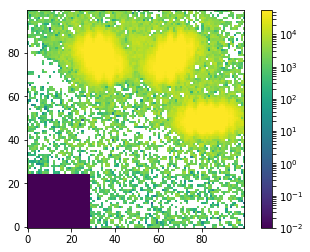

<Figure size 432x288 with 0 Axes>

In [26]:
# inject some overlapping test fake planets

junk = np.zeros(np.shape(fit_unsat["recon_2d"]))
y_cen, x_cen = 0.5*(np.subtract(np.shape(fit_unsat["recon_2d"]),1.))

# loop over all elements in the parameter vector
for pos_num in range(0,len(experiment_vector)):
    reconImg_shifted = scipy.ndimage.interpolation.shift(
        fit_unsat["recon_2d"],
        shift = [experiment_vector["y_pix_coord"][pos_num], experiment_vector["x_pix_coord"][pos_num]]) # shift in +y,+x convention
    junk = np.add(junk,reconImg_shifted)

plt.imshow(junk, norm=LogNorm(vmin=0.01, vmax=55000), origin="lower")
plt.colorbar()
plt.show()
plt.clf()

fake planet parameter vector:
ampl_linear_norm        1.000000
angle_deg               0.000000
rad_asec                0.300000
rad_pix                28.037383
ampl_linear_abs     60224.858360
x_pix_coord            28.037383
y_pix_coord             0.000000
Name: 0, dtype: float64


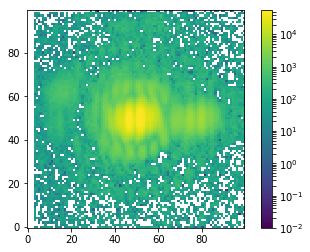

In [27]:
# inject one planet

y_cen, x_cen = 0.5*(np.subtract(np.shape(fit_unsat["recon_2d"]),1.))
ampl_norm = 0.1

# reconstructed host star PSF, amplitude of 1
pos_num = 0
print("fake planet parameter vector:")
print(experiment_vector.iloc[pos_num])
reconImg_shifted = scipy.ndimage.interpolation.shift(
        fit_unsat["recon_2d"],
        shift = [experiment_vector["y_pix_coord"][pos_num], 
                 experiment_vector["x_pix_coord"][pos_num]]) # shift in +y,+x convention

# inject flux-scaled planet
image_wo_fake_planet = np.copy(sciImg)
image_w_fake_planet = np.add(sciImg, ampl_norm*reconImg_shifted)

plt.imshow(image_w_fake_planet, norm=LogNorm(vmin=0.01, vmax=55000), origin="lower")
plt.colorbar()

#plt.savefig("phys_star_plus_fake_planet.png")

plt.show()
#plt.clf()

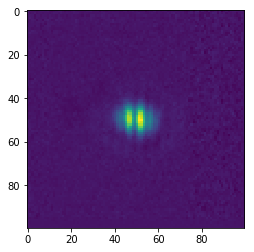

In [32]:
plt.imshow(fit_unsat["recon_2d"])
plt.show()

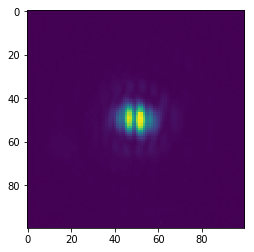

In [28]:
plt.imshow(sciImg)
plt.show()

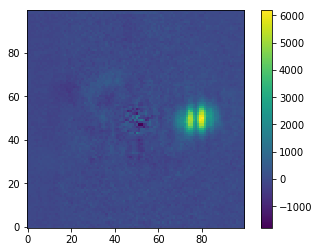

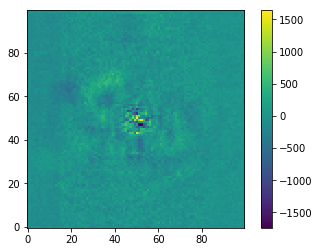

In [29]:
# now recover the fake planet

# step 1: subtract host star
star_subted = np.subtract(image_w_fake_planet,fit_sat["recon_2d"])
star_subted_wo_fake_planet = np.subtract(image_wo_fake_planet,fit_sat["recon_2d"])

# mask the regions near saturation
#star_subted = np.multiply(star_subted,mask_weird)

plt.imshow(star_subted, origin="lower")
plt.colorbar()
plt.show()

plt.imshow(star_subted_wo_fake_planet, origin="lower")
plt.colorbar()
plt.show()

#plt.savefig("host_star_subted_fake_planet.png")

In [30]:
star_subted_masked = np.multiply(star_subted,mask_weird)
print(np.nanstd(star_subted))
print(np.nanstd(star_subted_masked))


453.90551461315823
452.29840949520064


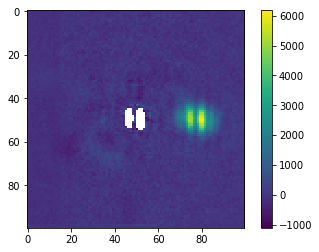

In [31]:
plt.imshow(star_subted_masked)
plt.colorbar()
plt.show()

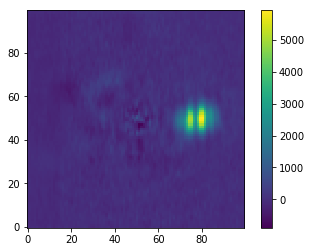

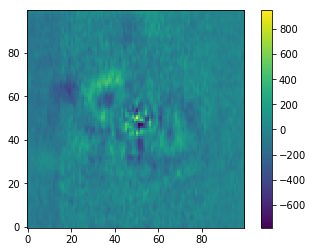

In [42]:
# step 2: smooth the image, so that the rms calculation will consider PSF-to-PSF variations
# N.B. A GAUSSIAN FILTER IS NOT APPROPRIATE; WE NEED TO SMOOTH WITH THE LBT FIZEAU PSF

sig_y = 9.46 # lambda/D, in pix
sig_x = 3.44 # lambda/B, in pix

smoothed = scipy.ndimage.filters.gaussian_filter(star_subted, 
                                                 sigma = np.multiply(0.1,[sig_y, sig_x]), 
                                                 order=0, 
                                                 output=None, 
                                                 mode='reflect', 
                                                 cval=0.0, 
                                                 truncate=4.0)

smoothed_wo_fake_planet = scipy.ndimage.filters.gaussian_filter(star_subted_wo_fake_planet, 
                                                 sigma = np.multiply(0.1,[sig_y, sig_x]), 
                                                 order=0, 
                                                 output=None, 
                                                 mode='reflect', 
                                                 cval=0.0, 
                                                 truncate=4.0)

plt.imshow(smoothed, origin="lower")
plt.colorbar()
plt.show()

plt.imshow(smoothed_wo_fake_planet, origin="lower")
plt.colorbar()
plt.show()

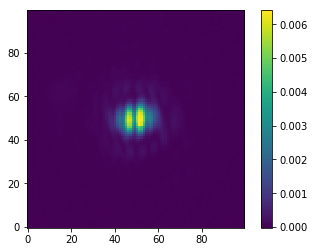

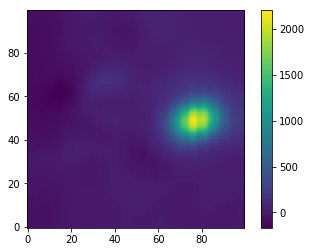

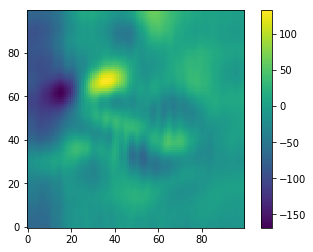

In [39]:
# step 2: smooth the image by convolving with an LBT Fizeau PSF

#sig_y = 9.46 # lambda/D, in pix
#sig_x = 3.44 # lambda/B, in pix

weights = np.divide(sciImg,np.sum(sciImg)) # normalize the host star PSF

smoothed2 = ndimage.filters.convolve(star_subted, 
                                    weights, 
                                    output=None, 
                                    mode='reflect', 
                                    cval=0.0, 
                                    origin=0) 

smoothed_wo_fake_planet2 = ndimage.filters.convolve(star_subted_wo_fake_planet, 
                                                   weights, 
                                                   output=None, 
                                                   mode='reflect', 
                                                   cval=0.0, 
                                                   origin=0) 

plt.imshow(weights, origin="lower")
plt.colorbar()
plt.show()

plt.imshow(smoothed2, origin="lower")
plt.colorbar()
plt.show()

plt.imshow(smoothed_wo_fake_planet2, origin="lower")
plt.colorbar()
plt.show()

In [44]:
hdu = fits.PrimaryHDU(star_subted, header=header)
hdul = fits.HDUList([hdu])
hdul.writeto("test_notsmoothed.fits", overwrite=True)

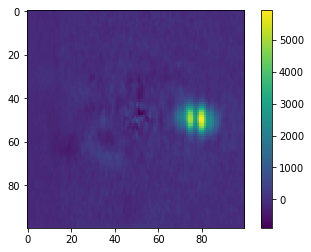

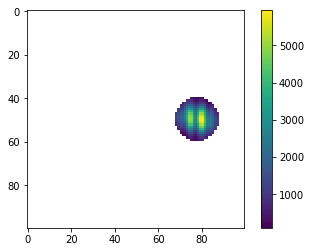

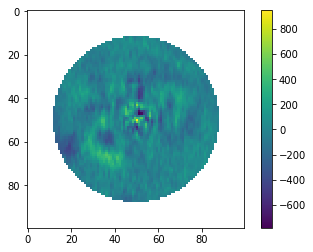

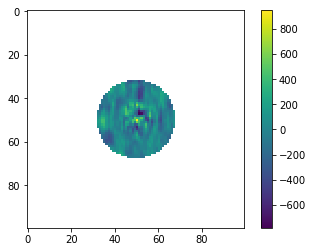

54.49076388625616


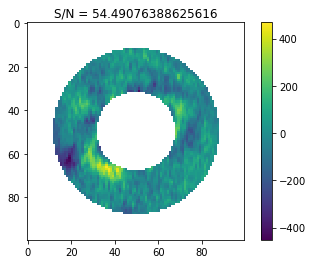

In [43]:
# step 3: determine signal level in fake planet PSF

# define region where fake planet is supposed to be: a circle near (y,x) of injection

circRad = 10 # pixels in FFT space

# N.b. for a 100x100 image, the physical center is at Python coordinate (49.5,49.5)
# i.e., in between pixels 49 and 50 in both dimensions (Python convention),
# or at coordinate (50.5,50.5) in DS9 convention
x_cen = 0.5*np.shape(smoothed)[0]-0.5
y_cen = 0.5*np.shape(smoothed)[1]-0.5

circle_fake_psf_premask = CirclePixelRegion(center=PixCoord(x=x_cen+experiment_vector["x_pix_coord"][pos_num],
                                                    y=y_cen+experiment_vector["y_pix_coord"][pos_num]), 
                                    radius=circRad)

fake_psf_outer_edge_rad = experiment_vector["x_pix_coord"][pos_num] + circRad
fake_psf_inner_edge_rad = experiment_vector["x_pix_coord"][pos_num] - circRad

annulus_noise_premask_outer = CirclePixelRegion(center=PixCoord(x=x_cen,y=y_cen),
                                          radius=fake_psf_outer_edge_rad)
annulus_noise_premask_inner = CirclePixelRegion(center=PixCoord(x=x_cen,y=y_cen),
                                          radius=fake_psf_inner_edge_rad)


# make the mask
mask_circ = circle_fake_psf_premask.to_mask()
mask_annulus_inner = annulus_noise_premask_inner.to_mask()
mask_annulus_outer = annulus_noise_premask_outer.to_mask()

sciImg1 = np.copy(smoothed)
    
plt.imshow(sciImg1)
plt.colorbar()
plt.show()
    
# display area around PSF to find amplitude of fake planet
sciImg1.fill(np.nan) # initialize arrays of nans
mask_circ.data[mask_circ.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
sciImg1[mask_circ.bbox.slices] = mask_circ.data  # place the mask cutout (consisting only of 1s) onto the array of nans
sciImgAroundPSF = np.multiply(sciImg1,smoothed) # 'transmit' the original science image through the mask
plt.imshow(sciImgAroundPSF)
plt.colorbar()
plt.show()
#plt.savefig('test_psf.png')

# display area in annulus with radius of that of the planet, but without planet itself

sciImg1.fill(np.nan) # initialize arrays of nans
mask_annulus_outer.data[mask_annulus_outer.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
sciImg1[mask_annulus_outer.bbox.slices] = mask_annulus_outer.data  # place the mask cutout (consisting only of 1s) onto the array of nans
sciImgOuter = np.multiply(sciImg1,smoothed_wo_fake_planet) # 'transmit' the original science image through the mask

plt.imshow(sciImgOuter)
plt.colorbar()
plt.show()

sciImg1.fill(np.nan) # initialize arrays of nans
mask_annulus_inner.data[mask_annulus_inner.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
sciImg1[mask_annulus_inner.bbox.slices] = mask_annulus_inner.data  # place the mask cutout (consisting only of 1s) onto the array of nans
sciImgInner = np.multiply(sciImg1,smoothed_wo_fake_planet) # 'transmit' the original science image through the mask

plt.imshow(sciImgInner)
plt.colorbar()
plt.show()


sciImgInner_zeros = np.nan_to_num(sciImgInner)
sciImgOuter_zeros = np.nan_to_num(sciImgOuter)
sciImgAroundPSF_zeros = np.nan_to_num(sciImgAroundPSF)


img8 = np.subtract(sciImgOuter_zeros,sciImgInner_zeros)
img8[img8 == 0] = np.nan

signal1 = np.subtract(np.nanmax(sciImgAroundPSF),np.nanstd(img8))
noise1 = np.nanstd(img8)

print(np.divide(signal1,noise1))

plt.imshow(img8)
plt.title("S/N = " + str(np.divide(signal1,noise1)))
plt.colorbar()
#plt.show()

#plt.imshow(np.subtract(sciImgOuter,sciImgInner))
#plt.colorbar()
#plt.show()

plt.savefig('test.png')
#plt.show()

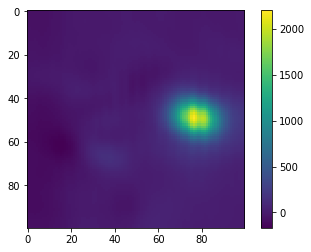

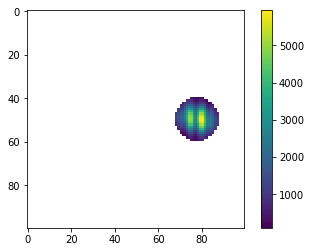

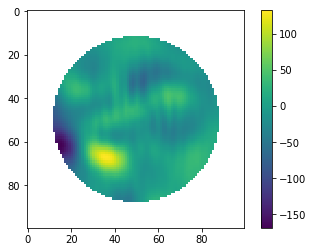

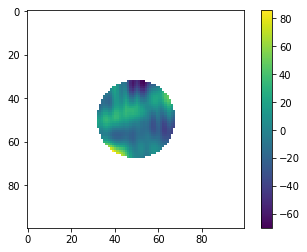

155.00140445054774


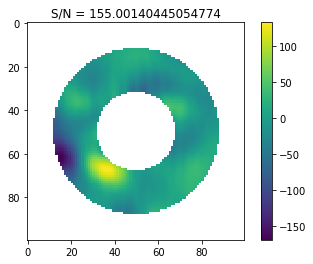

In [44]:
# step 3: determine signal level in fake planet PSF

# define region where fake planet is supposed to be: a circle near (y,x) of injection

circRad = 10 # pixels in FFT space

# N.b. for a 100x100 image, the physical center is at Python coordinate (49.5,49.5)
# i.e., in between pixels 49 and 50 in both dimensions (Python convention),
# or at coordinate (50.5,50.5) in DS9 convention
x_cen = 0.5*np.shape(smoothed)[0]-0.5
y_cen = 0.5*np.shape(smoothed)[1]-0.5

circle_fake_psf_premask = CirclePixelRegion(center=PixCoord(x=x_cen+experiment_vector["x_pix_coord"][pos_num],
                                                    y=y_cen+experiment_vector["y_pix_coord"][pos_num]), 
                                    radius=circRad)

fake_psf_outer_edge_rad = experiment_vector["x_pix_coord"][pos_num] + circRad
fake_psf_inner_edge_rad = experiment_vector["x_pix_coord"][pos_num] - circRad

annulus_noise_premask_outer = CirclePixelRegion(center=PixCoord(x=x_cen,y=y_cen),
                                          radius=fake_psf_outer_edge_rad)
annulus_noise_premask_inner = CirclePixelRegion(center=PixCoord(x=x_cen,y=y_cen),
                                          radius=fake_psf_inner_edge_rad)


# make the mask
mask_circ = circle_fake_psf_premask.to_mask()
mask_annulus_inner = annulus_noise_premask_inner.to_mask()
mask_annulus_outer = annulus_noise_premask_outer.to_mask()

sciImg1 = np.copy(smoothed2)
    
plt.imshow(sciImg1)
plt.colorbar()
plt.show()
    
# display area around PSF to find amplitude of fake planet
sciImg1.fill(np.nan) # initialize arrays of nans
mask_circ.data[mask_circ.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
sciImg1[mask_circ.bbox.slices] = mask_circ.data  # place the mask cutout (consisting only of 1s) onto the array of nans
sciImgAroundPSF = np.multiply(sciImg1,smoothed) # 'transmit' the original science image through the mask
plt.imshow(sciImgAroundPSF)
plt.colorbar()
plt.show()
#plt.savefig('test_psf.png')

# display area in annulus with radius of that of the planet, but without planet itself

sciImg1.fill(np.nan) # initialize arrays of nans
mask_annulus_outer.data[mask_annulus_outer.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
sciImg1[mask_annulus_outer.bbox.slices] = mask_annulus_outer.data  # place the mask cutout (consisting only of 1s) onto the array of nans
sciImgOuter = np.multiply(sciImg1,smoothed_wo_fake_planet2) # 'transmit' the original science image through the mask

plt.imshow(sciImgOuter)
plt.colorbar()
plt.show()

sciImg1.fill(np.nan) # initialize arrays of nans
mask_annulus_inner.data[mask_annulus_inner.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
sciImg1[mask_annulus_inner.bbox.slices] = mask_annulus_inner.data  # place the mask cutout (consisting only of 1s) onto the array of nans
sciImgInner = np.multiply(sciImg1,smoothed_wo_fake_planet2) # 'transmit' the original science image through the mask

plt.imshow(sciImgInner)
plt.colorbar()
plt.show()


sciImgInner_zeros = np.nan_to_num(sciImgInner)
sciImgOuter_zeros = np.nan_to_num(sciImgOuter)
sciImgAroundPSF_zeros = np.nan_to_num(sciImgAroundPSF)


img8 = np.subtract(sciImgOuter_zeros,sciImgInner_zeros)
img8[img8 == 0] = np.nan

signal1 = np.subtract(np.nanmax(sciImgAroundPSF),np.nanstd(img8))
noise1 = np.nanstd(img8)

print(np.divide(signal1,noise1))

plt.imshow(img8)
plt.title("S/N = " + str(np.divide(signal1,noise1)))
plt.colorbar()
#plt.show()

#plt.imshow(np.subtract(sciImgOuter,sciImgInner))
#plt.colorbar()
#plt.show()

plt.savefig('test.png')
#plt.show()

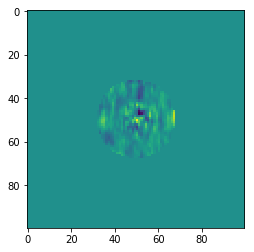

In [104]:
plt.imshow(np.nan_to_num(sciImgInner))
plt.show()

In [102]:
print(np.nanmedian(test))

0.0


In [41]:
ampl_recovered = np.nanmax(sciImg1)
print(ampl_recovered)

5935.519958024089


lm_180507_009000_nPCA164.fits


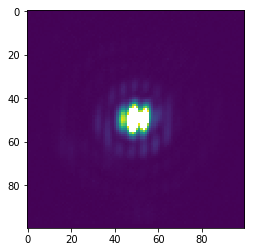

In [42]:
framenum = 9000

#### BELOW FOR FOR LOOP
# fit 2D Gaussian
img_string = 'lm_180507_'+str("{:0>6d}".format(framenum))+'_nPCA164.fits'
    
# if file exists
if os.path.isfile(stem_retrieve+img_string):
        
    # read in image
    sciImg, header = fits.getdata(stem_retrieve+img_string,0,header=True)
        
    print(img_string)
        
    sciImg_masked = np.copy(sciImg)
    mask_threshold = 35000 # pixel counts above this will be masked (refine this later based on linearity data)
    sciImg_masked[sciImg_masked > mask_threshold] = np.nan
        
    #plt.hist(np.ravel(sciImg), bins=1000)
    #plt.xlim([0,5000])
        
    plt.imshow(sciImg_masked)
    plt.show()
    
    # find the PCA spectrum 
    

In [3]:
# Make cookie cut-outs of Fizeau PSFs (note the centering will not be great)
# retrieve from /03_ramp_removed_pca_background_subted/
# deposit in /04_gross_cookie_cutout/

In [ ]:
########################################################################################################################

# Now upsample and center the images again, without using PynPoint (requires Python 3.5 for plots)

In [25]:
#%matplotlib qt

In [4]:
# read in cutout frames

def center_cutouts(framenum):
    '''
    Center PSF cutouts without using PynPoint
    '''

    # fit 2D Gaussian
    img_string = 'lm_180507_'+str("{:0>6d}".format(framenum))+'_nPCA164.fits'
    
    # if file exists
    if os.path.isfile(stem_place+img_string):
        
        # read in image
        sciImg, header = fits.getdata(stem_place+img_string,0,header=True)
        
        # get coordinate grid info
        y, x = np.mgrid[0:np.shape(sciImg)[0],0:np.shape(sciImg)[1]]
        z = np.copy(sciImg)
        
        # make an initial Gaussian guess
        p_init = models.Gaussian2D(amplitude=60000.,
                                   x_mean=50.,
                                   y_mean=50.,
                                   x_stddev=6.,
                                   y_stddev=6.)
        fit_p = fitting.LevMarLSQFitter()

        # fit the data
        p = fit_p(p_init, x, y, z)
        ampl, x_mean, y_mean, x_stdev, y_stdev, theat = p._parameters
        
        # Plot the data with the best-fit model
        '''
        plt.clf()
        plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 1)
        plt.imshow(z, origin='lower', interpolation='nearest', vmin=-10, vmax=60000)
        plt.title("Data")
        plt.subplot(1, 3, 2)
        plt.imshow(p(x, y), origin='lower', interpolation='nearest', vmin=-10, vmax=60000)
        plt.title("Model")
        plt.subplot(1, 3, 3)
        plt.imshow(z - p(x, y), origin='lower', interpolation='nearest', vmin=-10, vmax=60000)
        plt.title("Residual")
        plt.suptitle("Frame "+str("{:0>6d}".format(framenum)))
        plt.savefig(stem_place_centered+'pngs_fits/png_fit_lm_180507_'+str("{:0>6d}".format(framenum))+'.png',overwrite=True)
        plt.close()
        '''
                
        # center the frame
        # N.b. for a 100x100 image, the physical center is at Python coordinate (49.5,49.5)
        # i.e., in between pixels 49 and 50 in both dimensions (Python convention),
        # or at coordinate (50.5,50.5) in DS9 convention
        sciImg_shifted = scipy.ndimage.interpolation.shift(sciImg, shift = [49.5-y_mean, 49.5-x_mean]) # shift in +y,+x convention
        
        # write a cookie-cut frame back out
        hdu = fits.PrimaryHDU(sciImg_shifted,header=header)
        hdul = fits.HDUList([hdu])
        hdul.writeto(stem_place_centered+'lm_180507_'+str("{:0>6d}".format(framenum))+'_nPCA164.fits', 
                     overwrite=True)
        
        print("Centered frame "+str("{:0>6d}".format(framenum)))